In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pdf
from sklearn.utils import check_array 
from sklearn import preprocessing 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm

In [2]:
#print multiple statements in same line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity ="all"
%matplotlib inline

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
dfFeederData = pd.read_csv('Train_Feeder_40.csv', parse_dates=['ConsumptionDate'], index_col='ConsumptionDate',date_parser=dateparse)
print ('\n Parsed Data:')
dfFeederData.head()


 Parsed Data:


,Feeder,Demand,Revenue
ConsumptionDate,,,
2019-01-01,Feeder_40,163626,1131403.79
2019-02-01,Feeder_40,145540,1051194.12
2019-03-01,Feeder_40,135927,949335.35
2019-04-01,Feeder_40,237519,1536194.98
2019-05-01,Feeder_40,155266,1096483.49


In [4]:
size = int(len(dfFeederData)*.8)
size

4

In [5]:
train = dfFeederData.iloc[:size]
test = dfFeederData.iloc[size:]

In [6]:
train.head(10)
train.tail(10)
test.head(10)
test.tail(10)

,Feeder,Demand,Revenue
ConsumptionDate,,,
2019-01-01,Feeder_40,163626,1131403.79
2019-02-01,Feeder_40,145540,1051194.12
2019-03-01,Feeder_40,135927,949335.35
2019-04-01,Feeder_40,237519,1536194.98


,Feeder,Demand,Revenue
ConsumptionDate,,,
2019-01-01,Feeder_40,163626,1131403.79
2019-02-01,Feeder_40,145540,1051194.12
2019-03-01,Feeder_40,135927,949335.35
2019-04-01,Feeder_40,237519,1536194.98


,Feeder,Demand,Revenue
ConsumptionDate,,,
2019-05-01,Feeder_40,155266,1096483.49
2019-06-01,Feeder_40,162268,1294863.47


,Feeder,Demand,Revenue
ConsumptionDate,,,
2019-05-01,Feeder_40,155266,1096483.49
2019-06-01,Feeder_40,162268,1294863.47


In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true
    y_pred
   #    y_true, y_pred = check_array(y_true, y_pred)
   
    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)
    print(np.abs((y_true - y_pred) / y_true))
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
y_Result = test.copy()
y_Result = y_Result.iloc[0:1]
y_Result = y_Result.drop(['Revenue','Demand'], axis = 1)

y_Result

,Feeder
ConsumptionDate,
2019-05-01,Feeder_40


### Naive Approach

In [9]:
dd= np.asarray(train.Demand)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Naive Forecast')

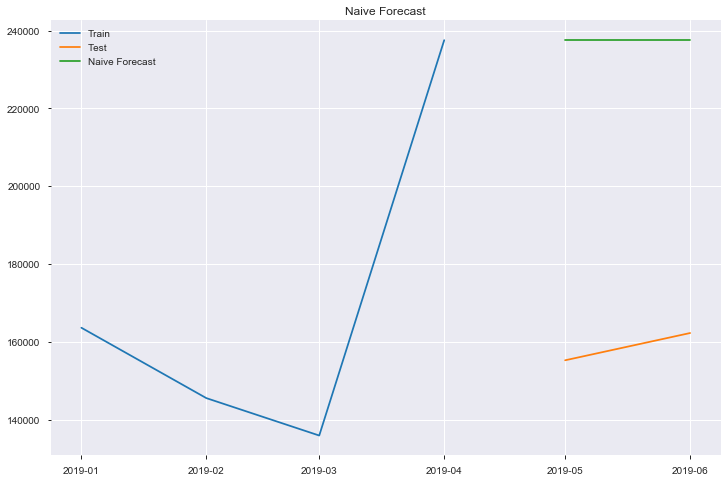

In [10]:
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Demand'], label='Train')
plt.plot(test.index,test['Demand'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [11]:
y_Result['naive-MSE'] = mean_squared_error(test.Demand, y_hat.naive)
y_Result['naive-MAE'] = mean_absolute_error(test.Demand, y_hat.naive)
y_Result['naive-MAPE'] = mean_absolute_percentage_error(test.Demand, y_hat.naive)
print('RMSE with naive approach : ')
y_Result

ConsumptionDate
2019-05-01    0.529755
2019-06-01    0.463745
dtype: float64
RMSE with naive approach : 


,Feeder,naive-MSE,naive-MAE,naive-MAPE
ConsumptionDate,,,,
2019-05-01,Feeder_40,6.214135e+09,78752.0,49.675027


### Simple Average

<Figure size 864x576 with 0 Axes>

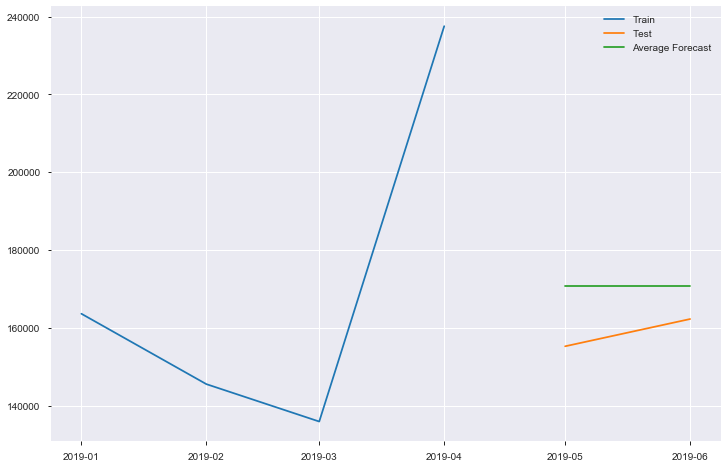

In [12]:
#y_hat = test.copy()
y_hat['avg_forecast'] = train['Demand'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['Demand'], label='Train')
plt.plot(test['Demand'], label='Test')
plt.plot(y_hat['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [13]:
rms = sqrt(mean_squared_error(test.Demand, y_hat.avg_forecast))
mean_absolute_percentage_error(test.Demand, y_hat.avg_forecast)
y_Result['SimpeAvg-MSE'] = mean_squared_error(test.Demand, y_hat.avg_forecast)
y_Result['SimpeAvg-MAE'] = mean_absolute_error(test.Demand, y_hat.avg_forecast)
y_Result['SimpeAvg-MAPE'] = mean_absolute_percentage_error(test.Demand, y_hat.avg_forecast)
print('RMSE with Simple Average approach : ', rms)
y_Result

ConsumptionDate
2019-05-01    0.099101
2019-06-01    0.051674
dtype: float64


7.538733603204004

ConsumptionDate
2019-05-01    0.099101
2019-06-01    0.051674
dtype: float64
RMSE with Simple Average approach :  12390.883624665354


,Feeder,naive-MSE,naive-MAE,naive-MAPE,SimpeAvg-MSE,SimpeAvg-MAE,SimpeAvg-MAPE
ConsumptionDate,,,,,,,
2019-05-01,Feeder_40,6.214135e+09,78752.0,49.675027,153533997.0,11886.0,7.538734


### Moving Average

In [14]:
#y_hat = test.copy()
y_hat['moving_avg_forecast'] = train['Demand'].rolling(3).mean().iloc[-1]

In [15]:
y_hat

,Feeder,Demand,Revenue,naive,avg_forecast,moving_avg_forecast
ConsumptionDate,,,,,,
2019-05-01,Feeder_40,155266,1096483.49,237519,170653.0,172995.333333
2019-06-01,Feeder_40,162268,1294863.47,237519,170653.0,172995.333333


<Figure size 1152x576 with 0 Axes>

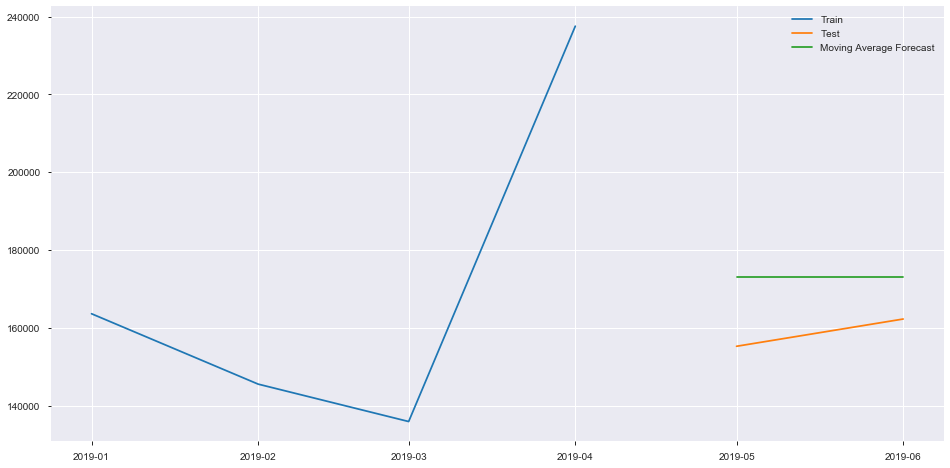

In [16]:
plt.figure(figsize=(16,8))
plt.plot(train['Demand'], label='Train')
plt.plot(test['Demand'], label='Test')
plt.plot(y_hat['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [17]:
rms = sqrt(mean_squared_error(test.Demand, y_hat.moving_avg_forecast))
mean_absolute_percentage_error(test.Demand, y_hat.moving_avg_forecast)
print('RMSE with Moving Average approach : ', rms)
y_Result['MovingAvg-MSE'] = mean_squared_error(test.Demand, y_hat.moving_avg_forecast)
y_Result['MovingAvg-MAE'] = mean_absolute_error(test.Demand, y_hat.moving_avg_forecast)
y_Result['MovingAvg-MAPE'] = mean_absolute_percentage_error(test.Demand, y_hat.moving_avg_forecast)
y_Result

ConsumptionDate
2019-05-01    0.114187
2019-06-01    0.066109
dtype: float64


9.014778913531037

RMSE with Moving Average approach :  14652.729112504767
ConsumptionDate
2019-05-01    0.114187
2019-06-01    0.066109
dtype: float64


,Feeder,naive-MSE,naive-MAE,naive-MAPE,SimpeAvg-MSE,SimpeAvg-MAE,SimpeAvg-MAPE,MovingAvg-MSE,MovingAvg-MAE,MovingAvg-MAPE
ConsumptionDate,,,,,,,,,,
2019-05-01,Feeder_40,6.214135e+09,78752.0,49.675027,153533997.0,11886.0,7.538734,2.147025e+08,14228.333333,9.014779


### Simple Exponential Smoothing

<Figure size 1152x576 with 0 Axes>

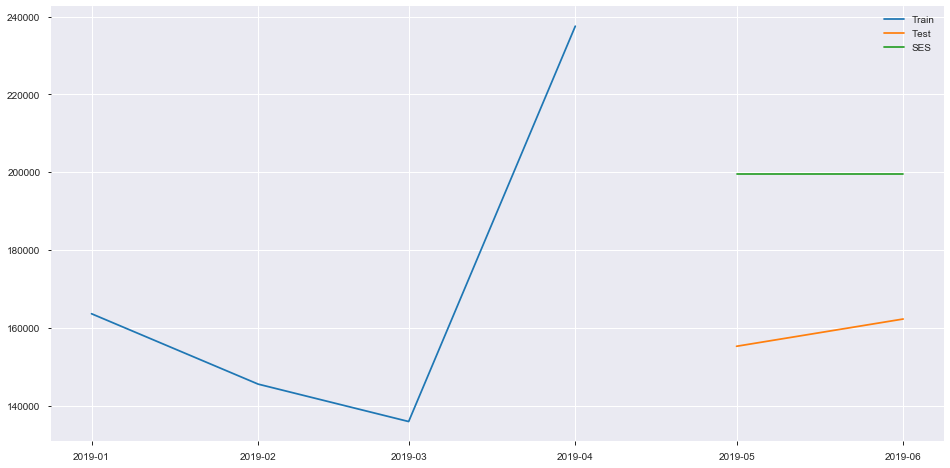

In [18]:
#y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Demand'])).fit(smoothing_level=0.6,optimized=False)
y_hat['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Demand'], label='Train')
plt.plot(test['Demand'], label='Test')
plt.plot(y_hat['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [19]:
error = mean_absolute_error(test.Demand,  y_hat.SES)

In [20]:
mean_absolute_percentage_error(test.Demand, y_hat.SES)

ConsumptionDate
2019-05-01    0.285393
2019-06-01    0.229927
dtype: float64


25.76598211982086

In [21]:
rms = sqrt(mean_squared_error(test.Demand, y_hat.SES))
print(rms)

40960.6773832496


In [22]:
y_Result['SES-MSE'] = mean_squared_error(test.Demand, y_hat.SES)
y_Result['SES-MAE'] = mean_absolute_error(test.Demand, y_hat.SES)
y_Result['SES-MAPE'] = mean_absolute_percentage_error(test.Demand, y_hat.SES)
y_Result

ConsumptionDate
2019-05-01    0.285393
2019-06-01    0.229927
dtype: float64


,Feeder,naive-MSE,naive-MAE,naive-MAPE,SimpeAvg-MSE,SimpeAvg-MAE,SimpeAvg-MAPE,MovingAvg-MSE,MovingAvg-MAE,MovingAvg-MAPE,SES-MSE,SES-MAE,SES-MAPE
ConsumptionDate,,,,,,,,,,,,,
2019-05-01,Feeder_40,6.214135e+09,78752.0,49.675027,153533997.0,11886.0,7.538734,2.147025e+08,14228.333333,9.014779,1.677777e+09,40810.784,25.765982


### Holt’s Linear Trend method

<Figure size 1440x720 with 0 Axes>

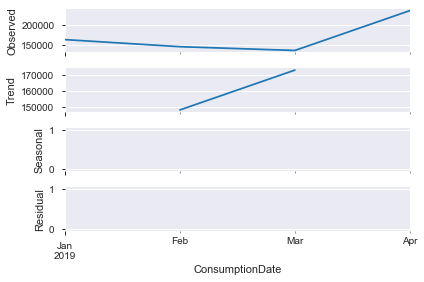

<Figure size 1440x720 with 0 Axes>

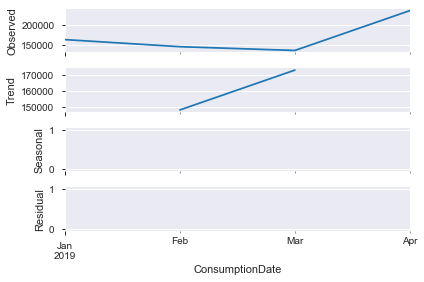

In [23]:
plt.figure(figsize=(20,10))
sm.tsa.seasonal_decompose(train.Demand,freq=3).plot()
result = sm.tsa.stattools.adfuller(train.Demand)
plt.show()

<Figure size 1152x576 with 0 Axes>

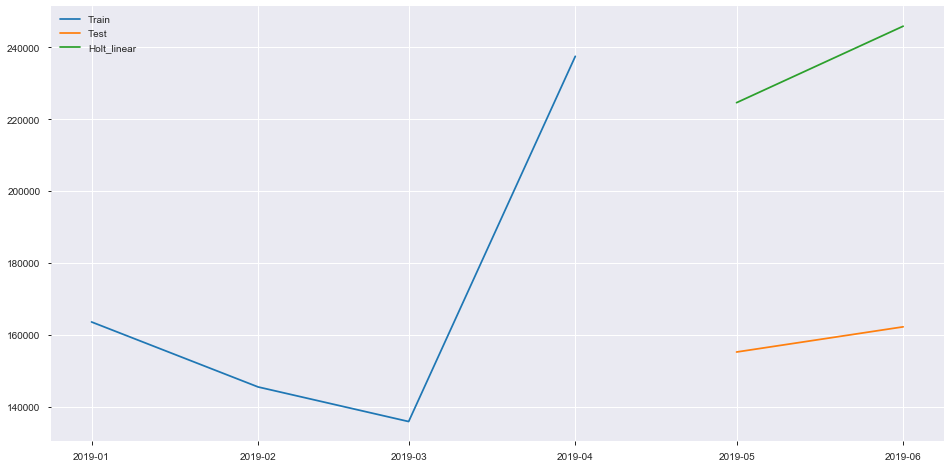

In [24]:
#y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['Demand'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['Demand'], label='Train')
plt.plot(test['Demand'], label='Test')
plt.plot(y_hat['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [25]:
rms = sqrt(mean_squared_error(test.Demand, y_hat.Holt_linear))
mean_absolute_percentage_error(test.Demand, y_hat.Holt_linear)
print(rms)

ConsumptionDate
2019-05-01    0.446699
2019-06-01    0.515410
dtype: float64


48.1054114853812

76828.17011539782


In [26]:
y_Result['Holt_linear-MSE'] = mean_squared_error(test.Demand, y_hat.Holt_linear)
y_Result['Holt_linear-MAE'] = mean_absolute_error(test.Demand, y_hat.Holt_linear)
y_Result['Holt_linear-MAPE'] = mean_absolute_percentage_error(test.Demand, y_hat.Holt_linear)
y_Result

ConsumptionDate
2019-05-01    0.446699
2019-06-01    0.515410
dtype: float64


,Feeder,naive-MSE,naive-MAE,naive-MAPE,SimpeAvg-MSE,SimpeAvg-MAE,SimpeAvg-MAPE,MovingAvg-MSE,MovingAvg-MAE,MovingAvg-MAPE,SES-MSE,SES-MAE,SES-MAPE,Holt_linear-MSE,Holt_linear-MAE,Holt_linear-MAPE
ConsumptionDate,,,,,,,,,,,,,,,,
2019-05-01,Feeder_40,6.214135e+09,78752.0,49.675027,153533997.0,11886.0,7.538734,2.147025e+08,14228.333333,9.014779,1.677777e+09,40810.784,25.765982,5.902568e+09,76495.797044,48.105411


### Holt-Winters method

C:\Users\kiran\Anaconda3\envs\TimeSeries\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


<Figure size 1152x576 with 0 Axes>

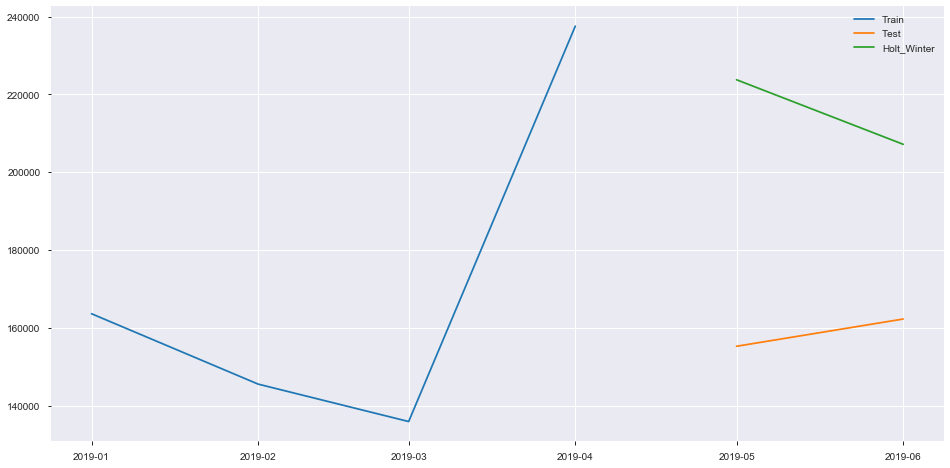

In [27]:
#y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Demand']) ,seasonal_periods=3 ,trend='add', seasonal='add',).fit()
y_hat['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['Demand'], label='Train')
plt.plot(test['Demand'], label='Test')
plt.plot(y_hat['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [28]:
rms = sqrt(mean_squared_error(test.Demand, y_hat.Holt_Winter))
mean_absolute_percentage_error(test.Demand, y_hat.Holt_Winter)
print(rms)

ConsumptionDate
2019-05-01    0.441090
2019-06-01    0.276708
dtype: float64


35.88992072815041

57907.094983451425


In [29]:
y_Result['Holt_Winter-MSE'] = mean_squared_error(test.Demand, y_hat.Holt_Winter)
y_Result['Holt_Winter-MAE'] = mean_absolute_error(test.Demand, y_hat.Holt_Winter)
y_Result['Holt_Winter-MAPE'] = mean_absolute_percentage_error(test.Demand, y_hat.Holt_Winter)
y_Result

ConsumptionDate
2019-05-01    0.441090
2019-06-01    0.276708
dtype: float64


,Feeder,naive-MSE,naive-MAE,naive-MAPE,SimpeAvg-MSE,SimpeAvg-MAE,SimpeAvg-MAPE,MovingAvg-MSE,MovingAvg-MAE,MovingAvg-MAPE,SES-MSE,SES-MAE,SES-MAPE,Holt_linear-MSE,Holt_linear-MAE,Holt_linear-MAPE,Holt_Winter-MSE,Holt_Winter-MAE,Holt_Winter-MAPE
ConsumptionDate,,,,,,,,,,,,,,,,,,,
2019-05-01,Feeder_40,6.214135e+09,78752.0,49.675027,153533997.0,11886.0,7.538734,2.147025e+08,14228.333333,9.014779,1.677777e+09,40810.784,25.765982,5.902568e+09,76495.797044,48.105411,3.353232e+09,56693.600451,35.889921


### ARIMA method

In [30]:
#y_hat = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.Demand, order=(0, 0, 0)).fit()
y_hat['SARIMA'] = fit1.predict(start="2019-5-1", end="2019-6-1", dynamic=True)

C:\Users\kiran\Anaconda3\envs\TimeSeries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [31]:
y_hat

,Feeder,Demand,Revenue,naive,avg_forecast,moving_avg_forecast,SES,Holt_linear,Holt_Winter,SARIMA
ConsumptionDate,,,,,,,,,,
2019-05-01,Feeder_40,155266,1096483.49,237519,170653.0,172995.333333,199577.784,224623.116643,223752.281120,0.0
2019-06-01,Feeder_40,162268,1294863.47,237519,170653.0,172995.333333,199577.784,245902.477445,207168.919781,0.0


<Figure size 1152x576 with 0 Axes>

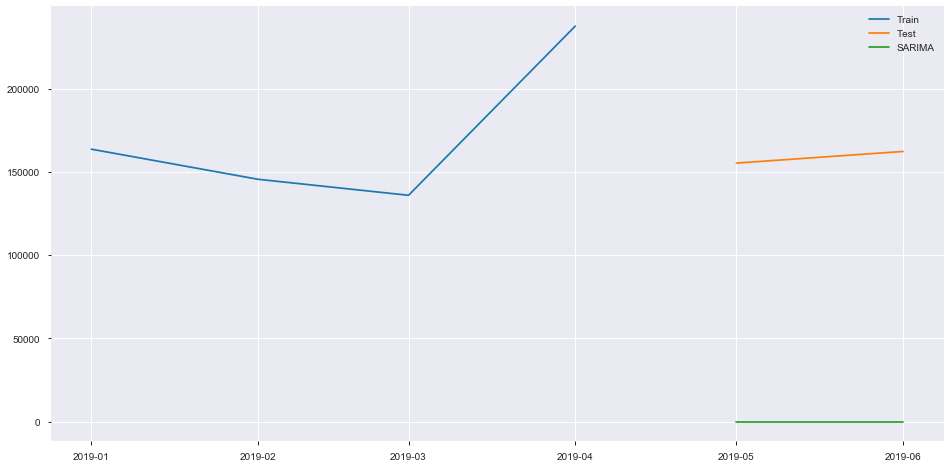

In [32]:
plt.figure(figsize=(16,8))
plt.plot( train['Demand'], label='Train')
plt.plot(test['Demand'], label='Test')
plt.plot(y_hat['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [33]:
rms = sqrt(mean_squared_error(test.Demand, y_hat.SARIMA))

mean_absolute_percentage_error(test.Demand, y_hat.SARIMA)
print(rms)

ConsumptionDate
2019-05-01    1.0
2019-06-01    1.0
dtype: float64


100.0

158805.59590266334


In [34]:
y_Result['SARIMA-MSE'] = mean_squared_error(test.Demand, y_hat.SARIMA)
y_Result['SARIMA-MAE'] = mean_absolute_error(test.Demand, y_hat.SARIMA)
y_Result['SARIMA-MAPE'] = mean_absolute_percentage_error(test.Demand, y_hat.SARIMA)
y_Result

ConsumptionDate
2019-05-01    1.0
2019-06-01    1.0
dtype: float64


,Feeder,naive-MSE,naive-MAE,naive-MAPE,SimpeAvg-MSE,SimpeAvg-MAE,SimpeAvg-MAPE,MovingAvg-MSE,MovingAvg-MAE,MovingAvg-MAPE,...,SES-MAPE,Holt_linear-MSE,Holt_linear-MAE,Holt_linear-MAPE,Holt_Winter-MSE,Holt_Winter-MAE,Holt_Winter-MAPE,SARIMA-MSE,SARIMA-MAE,SARIMA-MAPE
ConsumptionDate,,,,,,,,,,,,,,,,,,,,,
2019-05-01,Feeder_40,6.214135e+09,78752.0,49.675027,153533997.0,11886.0,7.538734,2.147025e+08,14228.333333,9.014779,...,25.765982,5.902568e+09,76495.797044,48.105411,3.353232e+09,56693.600451,35.889921,2.521922e+10,158767.0,100.0


### Auto ARIMA method

In [35]:
import pmdarima as pm

C:\Users\kiran\Anaconda3\envs\TimeSeries\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\kiran\Anaconda3\envs\TimeSeries\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [36]:
# Fit your model
model = pm.auto_arima(train.Demand, seasonal=False)

C:\Users\kiran\Anaconda3\envs\TimeSeries\lib\site-packages\statsmodels\tsa\ar_model.py:763: RuntimeWarning: divide by zero encountered in log
  return np.log(self.sigma2) + (1 + self.df_model) * np.log(nobs)/nobs
C:\Users\kiran\Anaconda3\envs\TimeSeries\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\kiran\Anaconda3\envs\TimeSeries\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [37]:
# make your forecasts
test.shape[0]

2

In [38]:
forecasts = model.predict(test.shape[0])  # predict N steps into the future

In [39]:
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(dfFeederData.shape[0]-1)
x

array([0, 1, 2, 3, 4])

In [40]:
forecasts = pd.DataFrame(forecasts,index = test.index,columns=['Prediction'])
y_hat['AutoARIMA'] = forecasts

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

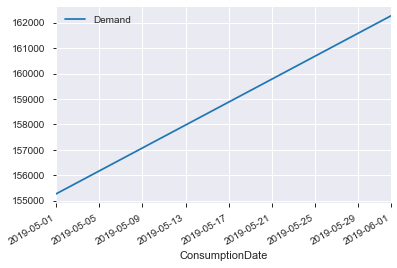

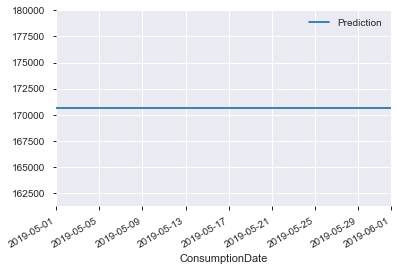

In [41]:
#plt.plot(test.Demand, c='blue')
#plt.plot(forecasts, c='green')
plt.figure(figsize = (20,10))
pd.DataFrame(test.Demand).plot()
pd.DataFrame(forecasts).plot()
plt.show()

In [42]:
rms=np.sqrt(np.mean(np.power((np.array(test.Demand)-np.array(forecasts['Prediction'])),2)))
mean_absolute_percentage_error(test.Demand, forecasts['Prediction'])
rms

ConsumptionDate
2019-05-01    0.099101
2019-06-01    0.051674
dtype: float64


7.538733603204004

12390.883624665354

In [43]:
y_Result['AutoARIMA-MSE'] = mean_squared_error(test.Demand, y_hat.AutoARIMA)
y_Result['AutoARIMA-MAE'] = mean_absolute_error(test.Demand, y_hat.AutoARIMA)
y_Result['AutoARIMA-MAPE'] = mean_absolute_percentage_error(test.Demand, y_hat.AutoARIMA)
y_Result

ConsumptionDate
2019-05-01    0.099101
2019-06-01    0.051674
dtype: float64


,Feeder,naive-MSE,naive-MAE,naive-MAPE,SimpeAvg-MSE,SimpeAvg-MAE,SimpeAvg-MAPE,MovingAvg-MSE,MovingAvg-MAE,MovingAvg-MAPE,...,Holt_linear-MAPE,Holt_Winter-MSE,Holt_Winter-MAE,Holt_Winter-MAPE,SARIMA-MSE,SARIMA-MAE,SARIMA-MAPE,AutoARIMA-MSE,AutoARIMA-MAE,AutoARIMA-MAPE
ConsumptionDate,,,,,,,,,,,,,,,,,,,,,
2019-05-01,Feeder_40,6.214135e+09,78752.0,49.675027,153533997.0,11886.0,7.538734,2.147025e+08,14228.333333,9.014779,...,48.105411,3.353232e+09,56693.600451,35.889921,2.521922e+10,158767.0,100.0,153533997.0,11886.0,7.538734


<Figure size 1440x576 with 0 Axes>

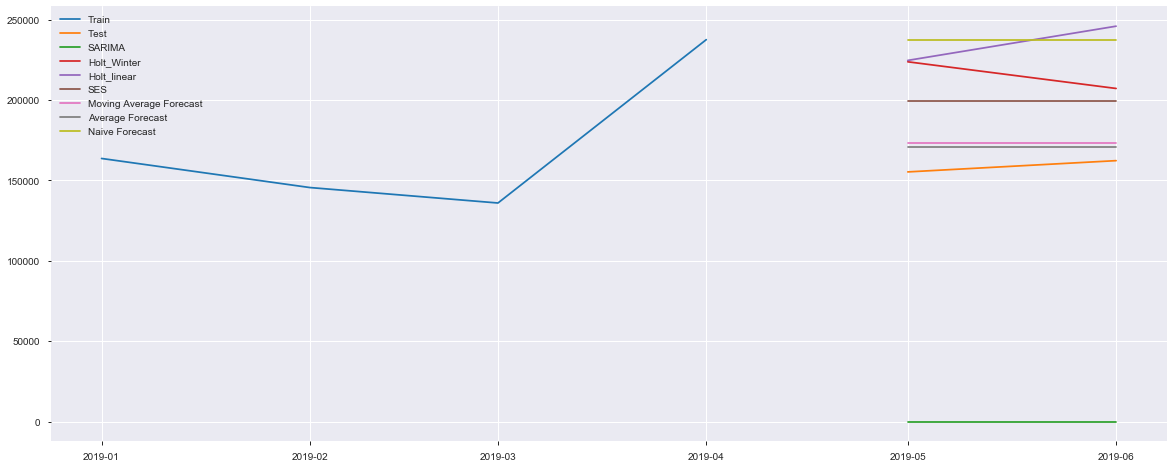

In [44]:
plt.figure(figsize=(20,8))
plt.plot( train['Demand'], label='Train')
plt.plot(test['Demand'], label='Test')
plt.plot(y_hat['SARIMA'], label='SARIMA')
plt.plot(y_hat['Holt_Winter'], label='Holt_Winter')
plt.plot(y_hat['Holt_linear'], label='Holt_linear')
plt.plot(y_hat['SES'], label='SES')
plt.plot(y_hat['moving_avg_forecast'], label='Moving Average Forecast')
plt.plot(y_hat['avg_forecast'], label='Average Forecast')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')

plt.legend(loc='best')
plt.show()

In [45]:
y_Result.to_csv('Feeder_40.csv')